In [57]:
# Import necessary libraries
from math import *
from scipy.integrate import dblquad
import numpy as np
from numpy import square as sqr
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
#import plotly.plotly as py
import sys,os
#sys.path.append(os.path.dirname(__file__), '..','Lib')
#sys.path.append(os.path.join('..','Lib'))
from stylelib.ase1_styles import ase1_sims_stl
plt.style.use(ase1_sims_stl)

In [20]:
# Set parameters for partition function integration
# Geometric parameters
xo = 100. # COM x separation
yo = 1. # COM y separation
theta = 0.0 # Angle between MTs
# Crosslinker parameters
k = 4.562 # spring constant
ho = 1.32 # equilibrium length
c = 40. # Crosslinker affinity * fugacity
# System parameters
b = 1. # beta
# MT parameters
hL = 100. # Half length of filaments
default_params = [xo, yo, k, ho, c, b]
default_params_gen = [xo, yo, theta, k, ho, c, b]

In [17]:
# Load data file
if os.path.exists('master.dat'):
    m_df = pd.read_csv('master.dat', delimiter=' ', header=0)
else:
    m_df = pd.DataFrame()

In [5]:
# If you want to save all the figures when they are made, set to True
savefigs = True

In [6]:
# Make sure you get right result TEST
# Bivariate Guassian distribution
const = 10. # strength of coupling
f1 = lambda x1, x2: np.exp(-0.5*const*(sqr(x1) + sqr(x2) - 2.*sqrt(1.-(1./const))*x1*x2))
# Integrate over -10 to 10 in both directions, if const is >> 1 then result should get close to one
q, _= dblquad(f1, -10,10, lambda x2:-10, lambda x2:10, epsabs=0, epsrel=1.e-8)
print (q*sqrt(const))/(2.*np.pi)

1.0


# Definition of functions

In [7]:
# For non-zero crosslinker length
def xlink_force_para(x1, x2, xo=10., yo=1.,  k=1., ho=0, c=1., b=1.):
    if ho == 0:
        return -1.*c*k*(x1 - x2 + xo)*np.exp(-.5*k*b*(np.power(x1-x2+xo,2)+np.power(yo,2)))
    else:
        return -1.*c*k*(x1 - x2 + xo)*(1. - (ho/np.sqrt(np.power(x1-x2+xo,2)+np.power(yo,2))))*np.exp(-.5*k*b*np.power(np.sqrt(np.power(x1-x2+xo,2)+np.power(yo,2))-ho, 2))
#fxo = lambda x1, x2, r:-1.*c*k*(x1 - x2 + r)*(1. - (ho/np.sqrt(np.power(x1-x2+r,2)+np.power(yo,2))))*np.exp(-.5*k*b*np.power(np.sqrt(np.power(x1-x2+r,2)+np.power(yo,2))-ho, 2))
#fxo = lambda x1, x2, r:-1.*c*k*(x1 - x2 + r)*np.exp(-.5*k*b*(np.power(x1-x2+r,2)+np.power(yo,2)))

In [8]:
def xlink_x_force_2D(s1, s2, xo=10., yo=1., theta=0.0, k=1., ho=0, c=1., b=1.):
    hSQR = sqr(xo)+sqr(yo) + sqr(s1) + sqr(s2) + 2.*s1*s2*np.cos(theta) - 2.*(xo*(s2*np.cos(theta)+s1)+s2*yo*np.sin(theta))
    if ho == 0:
        return -1.*c*k*(xo - s1 - s2*cos(theta))*np.exp(-.5*k*b*hSQR)
    else:
        return -1.*c*k*(xo - s1 - s2*cos(theta))*(1.-(ho/np.sqrt(hSQR)))*np.exp(-.5*k*b*(sqr(np.sqrt(hSQR)-ho)))

In [9]:
def xlink_y_force_2D(s1, s2, xo=10., yo=1., theta=0.0, k=1., ho=0, c=1., b=1.):
    hSQR = (xo**2+yo**2 + s1**2 + s2**2 + 2.*s1*s2*cos(theta) - 2.*(xo*(s2*cos(theta)+s1)+s2*yo*sin(theta)))
    if ho == 0:
        return -1.*c*k*(yo - s2*sin(theta))*exp(-.5*k*b*hSQR)
    else:
        return -1.*c*k*(yo - s2*sin(theta))*(1.-(ho/sqrt(hSQR)))*np.exp(-.5*k*b*(sqr(sqrt(hSQR)-ho)))

In [10]:
def xlink_torque_2D(x1, x2, xo=10., yo=1., theta=0.0, k=1., ho=0, c=1., b=1.):
    pass

In [11]:
# Partition function for parallel filaments returning the number of crosslinkers
def xlink_num_para(x1, x2, xo=10., yo=1.,  k=1., ho=0, c=1., b=1.):
    if ho == 0:
        return c*np.exp(-.5*k*b*(np.power(x1-x2+xo,2)+np.power(yo,2)))
    else:
        return c*np.exp(-.5*k*b*np.power(np.sqrt(np.power(x1-x2+xo,2)+np.power(yo,2))-ho, 2))
#Nxo = lambda x1, x2, r:c*np.exp(-.5*k*b*np.power(np.sqrt(np.power(x1-x2+r,2)+np.power(yo,2))-ho, 2))

In [12]:
def create_param_list(var_list, index, base_params=default_params):
    param_list = []
    for v in var_list:
        params = deepcopy(base_params) # Copy over the default parameters
        params[index] = v # Change the distance between MTs
        param_list += [params] # Add to the param list used in integration steps
    return param_list

In [25]:
def create_xo_func_array(n=100, base_params=default_params, hL1=10, hL2=10, xlink_func=xlink_force_para):
    xo_list = np.linspace(-202, 202, n).tolist()
    param_list = create_param_list(xo_list, 0, base_params)
    # Iterate over the different parameter sets and find the force
    f_list = [dblquad(xlink_func, -hL1, hL1, lambda x2:-hL2, lambda x2:hL2, args = p, epsabs=0, epsrel=1.e-13) for p in param_list]
    return xo_list, np.array(f_list)

# TESTS for single integrations

In [14]:
# Force between parallel filaments of equal length and no center separation, TEST Should return 0
params = deepcopy(default_params)
params[0] = 0
f, err = dblquad(xlink_force_para, -hL, hL, lambda x2:-hL, lambda x2:hL, args=params, epsabs=0, epsrel=1.e-13)
print f, err

/usr/local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


0.0 1.95978368656e-12


In [15]:
# Number of crosslinkers between parallel filaments of equal length and no center separation, TEST
params = deepcopy(default_params)
params[0] = 0
f, err = dblquad(xlink_num_para, -hL, hL, lambda x2:-hL, lambda x2:hL, args=params, epsabs=0, epsrel=1.e-13)
print f, err

24181.6971545 1.1791540659e-09


# Baseline entropic crosslinker forces

In [26]:
# Scan over multiple values of Delta r
if 'f_wt' not in m_df or True: # Change False to True if you want to re-run data
    xo_list, f_arr = create_xo_func_array(n=100,hL1=hL,hL2=hL)
    m_df['xo'] = xo_list
    m_df['f_wt'] = f_arr[:,0]
else:
    pass

IOError: [Errno 2] No such file or directory: 'graphs/force_wt.png'

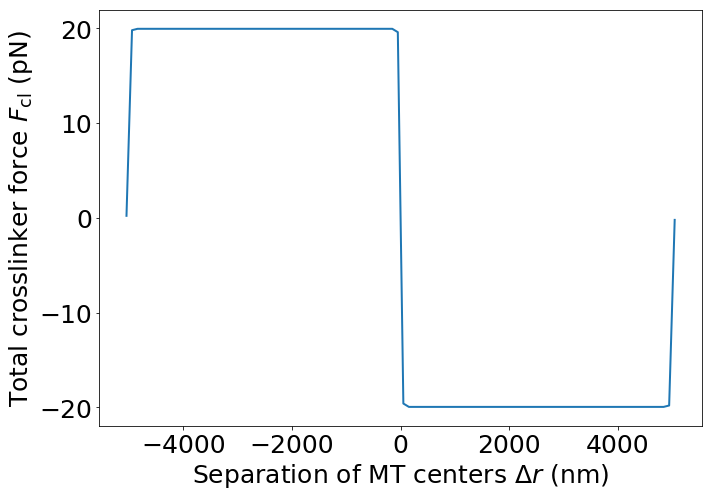

In [27]:
# Graph scan over area
fig, ax = plt.subplots(figsize=(10,7))
ax.errorbar(m_df['xo']*25., m_df['f_wt']*.1644)
#ax.set_xlim((-22,22))
ax.set_xlabel(r'Separation of MT centers $\Delta r$ (nm)')
ax.set_ylabel(r'Total crosslinker force $F_{\rm cl}$ (pN)')
if savefigs or True:
    plt.tight_layout()
    plt.savefig('graphs/force_wt.png')
plt.show()

In [29]:
# Number of crosslinkers from baseline of partition function
if 'N_wt' not in m_df or True: # Change False to True if you want to re-run data
    base_params = deepcopy(default_params)
    xo_list, N_arr = create_xo_func_array(100, base_params,hL1=hL,hL2=hL, xlink_func=xlink_num_para)
    m_df['xo'] = xo_list
    m_df['N_wt'] = N_arr[:,0]

IOError: [Errno 2] No such file or directory: 'graphs/N_wt.png'

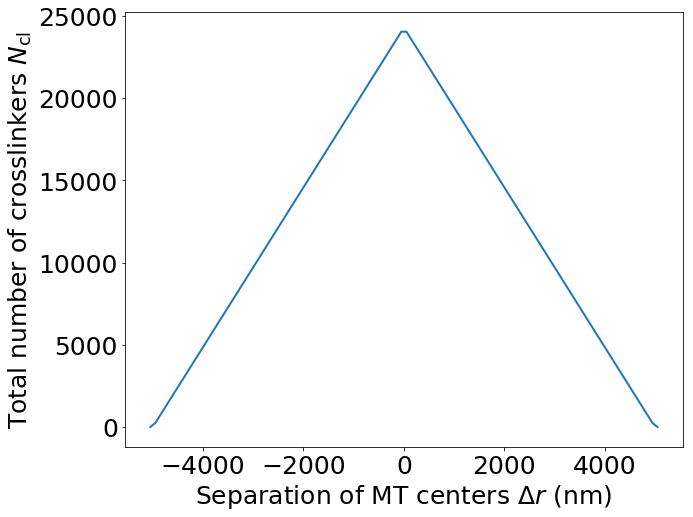

In [63]:
# Graph number of crosslinkers based off partition function
fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(m_df['xo']*25., m_df['N_wt'])
#ax.set_xlim((-22,22))
ax.set_xlabel(r'Separation of MT centers $\Delta r$ (nm)')
ax.set_ylabel(r'Total number of crosslinkers $N_{\rm cl}$')
if savefigs or False:
    plt.savefig('graphs/N_wt.png')
plt.show()


IOError: [Errno 2] No such file or directory: 'graphs/force_canon_wt_for_comps3.png'

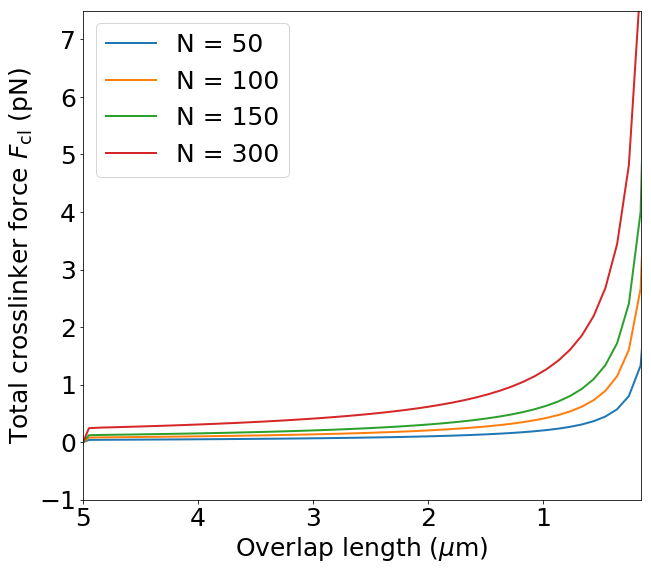

In [64]:
# Canonical force calculation
fig, ax = plt.subplots(figsize=(10,9))
N_list = [50,100,150,300] # Number of crosslinkers
#ax.set_xlim((40,500))
#ax.set_ylim((-4, 0))
for N in N_list:
    ax.plot(np.abs(.001*m_df['xo']*25.-5), -1.*N*np.divide(m_df['f_wt'],m_df['N_wt'])*.1644, label='N = {}'.format(N))
ax.set_xlabel(r'Overlap length ($\mu$m)')
ax.set_ylabel(r'Total crosslinker force $F_{\rm cl}$ (pN)')
ax.set_ylim(-1,7.5)
ax.set_xlim(5, .15)
ax.legend()
if savefigs or False:
    plt.savefig('graphs/force_canon_wt_for_comps3.png')
plt.show()

IOError: [Errno 2] No such file or directory: 'graphs/force_canon_wt.png'

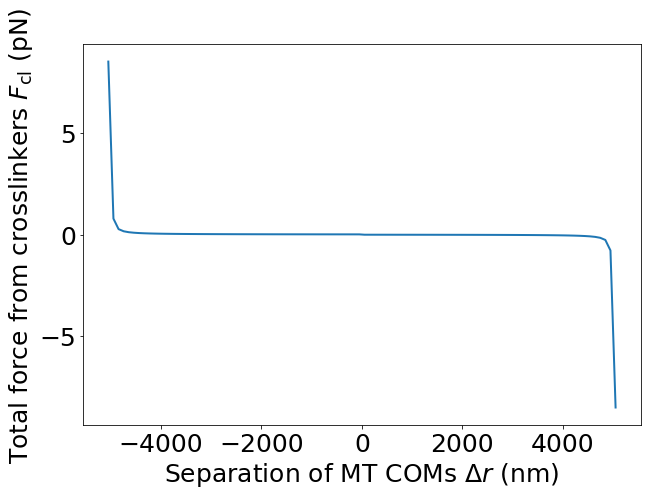

In [48]:
# Canonical force calculation
fig, ax = plt.subplots(figsize=(10,7))
N = 10 # Number of crosslinkers
#ax.set_xlim((40,500))
#ax.set_ylim((-4, 0))
ax.plot(m_df['xo']*25., N*np.divide(m_df['f_wt'],m_df['N_wt'])*.1644)
ax.set_xlabel(r'Separation of MT COMs $\Delta r$ (nm)')
ax.set_ylabel(r'Total force from crosslinkers $F_{\rm cl}$ (pN)')

if savefigs or False:
    plt.savefig('graphs/force_canon_wt.png')
plt.show()

# Geometry changes

In [51]:
# Changing yo
if 'f_yo1.25' not in m_df or True: # Change False to True if you want to re-run data
    base_params = deepcopy(default_params)
    base_params[1] = 1.25
    xo_list , fyo_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['xo'] = xo_list
    m_df['f_yo1.25'] = fyo_arr[:,0]
    base_params[1] = 1.50
    xo_list , fyo_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_yo1.5'] = fyo_arr[:,0]
    base_params[1] = 1.75
    xo_list , fyo_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_yo1.75'] = fyo_arr[:,0]
    base_params[1] = 2.0
    xo_list , fyo_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_yo2.0'] = fyo_arr[:,0]

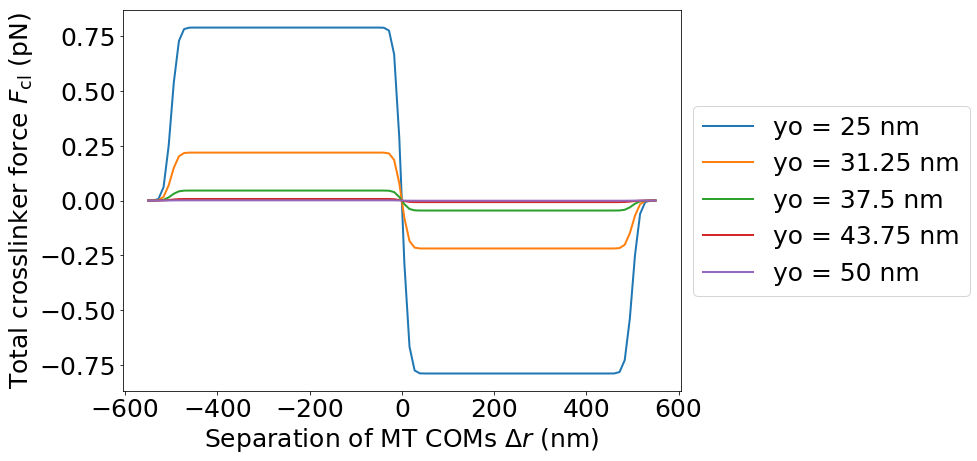

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
ax.errorbar(m_df['xo']*25., m_df['f_wt']*.1644, label='yo = 25 nm')
ax.errorbar(m_df['xo']*25., m_df['f_yo1.25']*.1644, label='yo = 31.25 nm')
ax.errorbar(m_df['xo']*25., m_df['f_yo1.5']*.1644, label='yo = 37.5 nm')
ax.errorbar(m_df['xo']*25., m_df['f_yo1.75']*.1644, label='yo = 43.75 nm')
ax.errorbar(m_df['xo']*25., m_df['f_yo2.0']*.1644, label='yo = 50 nm')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
#ax.set_xlim((-22,22))
ax.set_xlabel(r'Separation of MT COMs $\Delta r$ (nm)')
ax.set_ylabel(r'Total crosslinker force $F_{\rm cl}$ (pN)')
if savefigs or False:
    plt.savefig('graphs/force_yo.png',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


In [56]:
# Change MT2 length
if 'f_L2_5.0' not in m_df or False: # Change False to True if you want to re-run data
    base_params = deepcopy(default_params)
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, hL2=2.5)
    m_df['xo'] = xo_list
    m_df['f_L2_5.0'] = fLo_arr[:,0]
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, hL2=5)
    m_df['f_L2_10.0'] = fLo_arr[:,0]
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, hL2=7.5)
    m_df['f_L2_15.0'] = fLo_arr[:,0]
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, hL2=12.5)
    m_df['f_L2_25.0'] = fLo_arr[:,0]
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, hL2=15)
    m_df['f_L2_30.0'] = fLo_arr[:,0]

/usr/local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


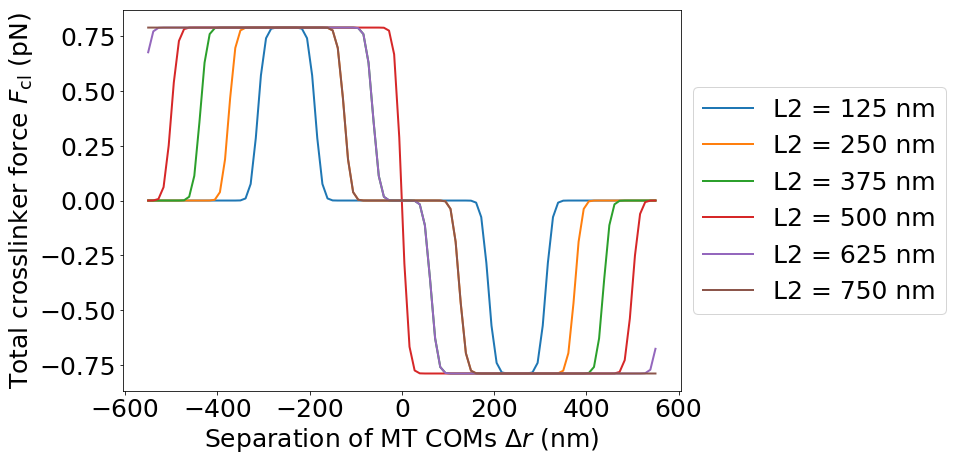

In [58]:
fig, ax = plt.subplots(figsize=(10,7))
ax.errorbar(m_df['xo']*25., m_df['f_L2_5.0']*.1644, label='L2 = 125 nm')
ax.errorbar(m_df['xo']*25., m_df['f_L2_10.0']*.1644, label='L2 = 250 nm')
ax.errorbar(m_df['xo']*25., m_df['f_L2_15.0']*.1644, label='L2 = 375 nm')
ax.errorbar(m_df['xo']*25., m_df['f_wt']*.1644, label='L2 = 500 nm')
ax.errorbar(m_df['xo']*25., m_df['f_L2_25.0']*.1644, label='L2 = 625 nm')
ax.errorbar(m_df['xo']*25., m_df['f_L2_30.0']*.1644, label='L2 = 750 nm')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
#ax.set_xlim((-22,22))
ax.set_xlabel(r'Separation of MT COMs $\Delta r$ (nm)')
ax.set_ylabel(r'Total crosslinker force $F_{\rm cl}$ (pN)')
if savefigs or False:
    plt.savefig('graphs/force_L2.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [32]:
# Change angle of MT2 relative to MT1
if 'f_theta_.05' not in m_df or False: # Change False to True if you want to re-run data
    base_params = deepcopy(default_params_gen)
    
    base_params[2] = .05
    xo_list , f_arr = create_xo_func_array(n=100, base_params=base_params, xlink_func=xlink_x_force_2D)
    m_df['xo'] = xo_list
    m_df['f_theta_.05'] = f_arr[:,0]
    """
    base_params[2] = .1
    xo_list , f_arr = create_xo_func_array(n=100, base_params=base_params, xlink_func=xlink_x_force_2D)
    m_df['xo'] = xo_list
    m_df['f_theta_.1'] = f_arr[:,0]
    
    base_params[2] = .3
    xo_list , f_arr = create_xo_func_array(n=100, base_params=base_params, xlink_func=xlink_x_force_2D)
    m_df['xo'] = xo_list
    m_df['f_theta_.3'] = f_arr[:,0]

    base_params[3] = .6
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, xlink_func=xlink_x_force_2D)
    m_df['f_theta_.6'] = fLo_arr[:,0]
   
    base_params[3] = .9
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, xlink_func=xlink_x_force_2D)
    m_df['f_theta_.9'] = fLo_arr[:,0]
    
    base_params[3] = 1.2
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, xlink_func=xlink_x_force_2D)
    m_df['f_theta_1.2'] = fLo_arr[:,0]
   
    base_params[3] = 1.5
    xo_list , fLo_arr = create_xo_func_array(n=100, base_params=base_params, xlink_func=xlink_x_force_2D)
    m_df['f_theta_1.5'] = fLo_arr[:,0]"""
    

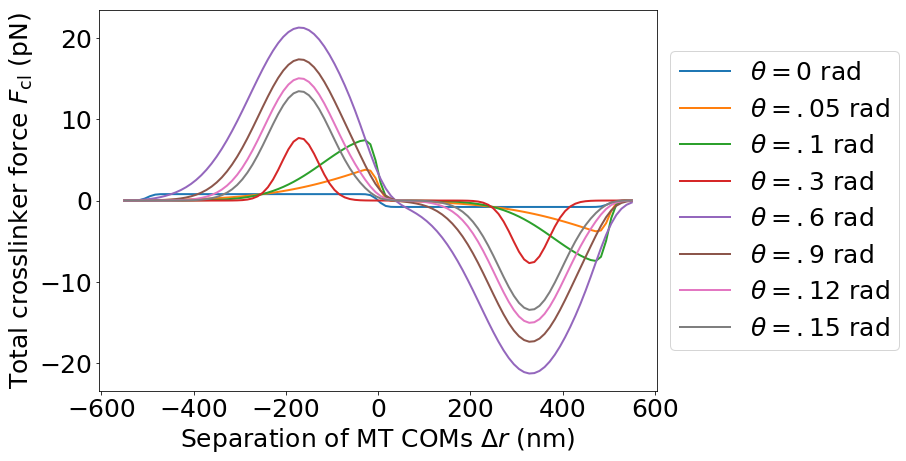

In [33]:
fig, ax = plt.subplots(figsize=(10,7))
ax.errorbar(m_df['xo']*25., m_df['f_wt']*.1644, label=r'$\theta = 0$ rad')
ax.errorbar(m_df['xo']*25., m_df['f_theta_.05']*.1644, label=r'$\theta = .05$ rad')
ax.errorbar(m_df['xo']*25., m_df['f_theta_.1']*.1644, label=r'$\theta = .1$ rad')
ax.errorbar(m_df['xo']*25., m_df['f_theta_.3']*.1644, label=r'$\theta = .3$ rad')
ax.errorbar(m_df['xo']*25., m_df['f_theta_.6']*.1644, label=r'$\theta = .6$ rad')
ax.errorbar(m_df['xo']*25., m_df['f_theta_.9']*.1644, label=r'$\theta = .9$ rad')
ax.errorbar(m_df['xo']*25., m_df['f_theta_1.2']*.1644, label=r'$\theta = .12$ rad')
ax.errorbar(m_df['xo']*25., m_df['f_theta_1.5']*.1644, label=r'$\theta = .15$ rad')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
ax.set_xlabel(r'Separation of MT COMs $\Delta r$ (nm)')
ax.set_ylabel(r'Total crosslinker force $F_{\rm cl}$ (pN)')
plt.show()

# Ase1 parameter changes

In [60]:
# Crosslinkers with some equilibrium length
if 'f_ho.25' not in m_df or False: # Change False to True if you want to re-run data
    base_params = deepcopy(default_params)
    base_params[3] = .25
    xo_list , fho_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['xo'] = xo_list
    m_df['f_ho.25'] = fho_arr[:,0]
    base_params[3] = .5
    xo_list ,fho_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_ho.5'] = fho_arr[:,0]
    base_params[3] = 1.
    xo_list ,fho_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_ho1'] = fho_arr[:,0]
    base_params[3] = 2.
    xo_list ,fho_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_ho2'] = fho_arr[:,0]
    base_params[3] = 2.5
    xo_list ,fho_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_ho2.5'] = fho_arr[:,0]
    base_params[3] = 3.0
    xo_list ,fho_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_ho3'] = fho_arr[:,0]

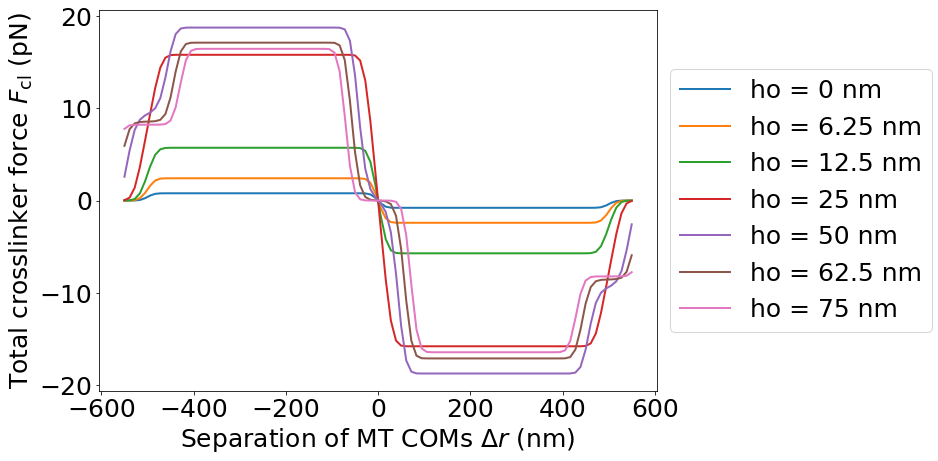

In [61]:
# Graph scan over area
fig, ax = plt.subplots(figsize=(10,7))
ax.errorbar(m_df['xo']*25., m_df['f_wt']*.1644, label='ho = 0 nm')
ax.errorbar(m_df['xo']*25., m_df['f_ho.25']*.1644, label='ho = 6.25 nm')
ax.errorbar(m_df['xo']*25., m_df['f_ho.5']*.1644, label='ho = 12.5 nm')
ax.errorbar(m_df['xo']*25., m_df['f_ho1']*.1644, label='ho = 25 nm')
ax.errorbar(m_df['xo']*25., m_df['f_ho2']*.1644, label='ho = 50 nm')
ax.errorbar(m_df['xo']*25., m_df['f_ho2.5']*.1644, label='ho = 62.5 nm')
ax.errorbar(m_df['xo']*25., m_df['f_ho3']*.1644, label='ho = 75 nm')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
#ax.set_xlim((-22,22))
ax.set_xlabel(r'Separation of MT COMs $\Delta r$ (nm)')
ax.set_ylabel(r'Total crosslinker force $F_{\rm cl}$ (pN)')
if savefigs or False:
    plt.savefig('graphs/force_ho.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [34]:
# Crosslinker spring constant
if 'f_k_0.5' not in m_df or True: # Change False to True if you want to re-run data
    base_params = deepcopy(default_params)
    base_params[2] = 0.5
    xo_list , fk_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['xo'] = xo_list
    m_df['f_k_0.5'] = fk_arr[:,0]
    base_params[2] = 1.0
    xo_list , fk_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_k_1.0'] = fk_arr[:,0]
    base_params[2] = 2.0
    xo_list , fk_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_k_2.0'] = fk_arr[:,0]
    base_params[2] = 3.0
    xo_list , fk_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_k_3.0'] = fk_arr[:,0]
    base_params[2] = 5.0
    xo_list , fk_arr = create_xo_func_array(n=100, base_params=base_params)
    m_df['f_k_5.0'] = fk_arr[:,0]
    

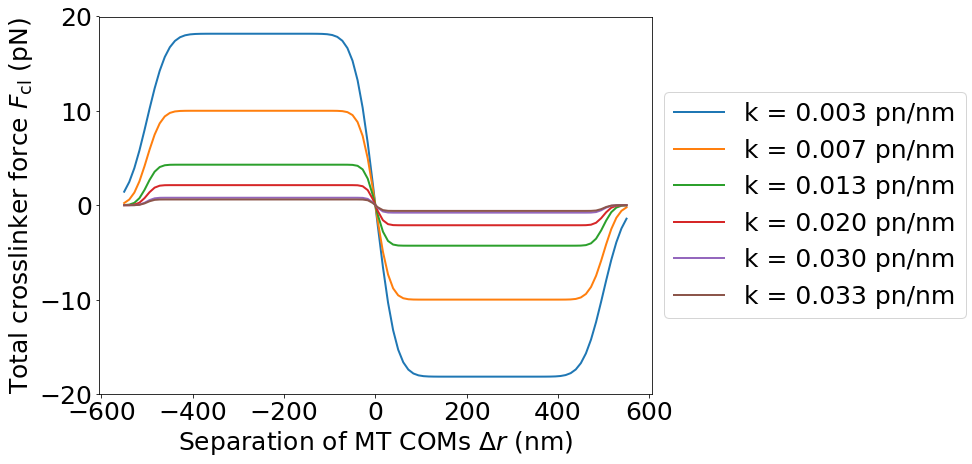

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
ax.errorbar(m_df['xo']*25., m_df['f_k_0.5']*.1644, label='k = {0:.3f} pn/nm'.format(.00657*.5))
ax.errorbar(m_df['xo']*25., m_df['f_k_1.0']*.1644, label='k = {0:.3f} pn/nm'.format(.00657*1.0))
ax.errorbar(m_df['xo']*25., m_df['f_k_2.0']*.1644, label='k = {0:.3f} pn/nm'.format(.00657*2.0))
ax.errorbar(m_df['xo']*25., m_df['f_k_3.0']*.1644, label='k = {0:.3f} pn/nm'.format(.00657*3.0))
ax.errorbar(m_df['xo']*25., m_df['f_wt']*.1644, label='k = {0:.3f} pn/nm'.format(.00657*4.562))
ax.errorbar(m_df['xo']*25., m_df['f_k_5.0']*.1644, label='k = {0:.3f} pn/nm'.format(.00657*5.0))
lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
ax.set_xlabel(r'Separation of MT COMs $\Delta r$ (nm)')
ax.set_ylabel(r'Total crosslinker force $F_{\rm cl}$ (pN)')
plt.tight_layout()
if savefigs or False:
    plt.savefig('graphs/force_k.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [36]:
# Save master dataframe afterwards
with open("master.dat", 'w') as datafile:
    m_df.to_csv(datafile, sep=" ", index=False)